In [132]:
import tensorflow as tf
import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
import seaborn as sns

import world_model
import plan_optimizer as po
import planning_cases

sns.set(style="whitegrid")
sns.set_context(context="paper")

In [133]:
result = pd.read_parquet("data/angle_test_condition_5.parquet", engine="pyarrow")
print(result.describe())
print(result.info())
print(result.head())
print(result["i"].unique())
result.tail()

         init_angle  init_speed          step         theta     theta_dot  \
count  18972.000000     18972.0  18972.000000  18972.000000  18972.000000   
mean       0.000000         0.0     25.000000      0.104089     -0.017967   
std       17.889015         0.0     14.719989      1.710157      1.610134   
min      -30.000000         0.0      0.000000     -4.777513     -5.257405   
25%      -16.000000         0.0     12.000000     -0.183680     -0.137699   
50%        0.000000         0.0     25.000000     -0.108843     -0.031395   
75%       16.000000         0.0     38.000000      0.110274      0.035438   
max       30.000000         0.0     50.000000      4.913328      5.525537   

                  i  
count  18972.000000  
mean       1.500000  
std        1.118063  
min        0.000000  
25%        0.750000  
50%        1.500000  
75%        2.250000  
max        3.000000  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18972 entries, 0 to 18971
Data columns (total 8 columns):


,condition,condtition,init_angle,init_speed,step,theta,theta_dot,i
18967,Last,None,30,0,46,2.717045,-1.996774,3
18968,Last,None,30,0,47,2.647653,-1.387842,3
18969,Last,None,30,0,48,2.581040,-1.332269,3
18970,Last,None,30,0,49,2.519363,-1.233528,3
18971,Last,None,30,0,50,2.464544,-1.096392,3


In [134]:
result.isna().sum()

condition      6324
condtition    12648
init_angle        0
init_speed        0
step              0
theta             0
theta_dot         0
i                 0
dtype: int64

In [135]:
result.loc[result["condition"].isna(),"condition"] = result.loc[result["condition"].isna(),"condtition"]

In [136]:
result.isna().sum()

condition         0
condtition    12648
init_angle        0
init_speed        0
step              0
theta             0
theta_dot         0
i                 0
dtype: int64

In [137]:
df[(df["i"]== 0) & (df["step"] == 40) & (df["init_angle"] == 0)]

,condition,condtition,init_angle,init_speed,step,theta,theta_dot,i,init_id,Angle
805,None,None,0,0,40,-7.568837,-0.022587,0,"(0, 0, None)",0
2386,First,First,0,0,40,-7.070497,-0.017929,0,"(0, 0, First)",0
3967,Last,None,0,0,40,-7.512811,-0.025149,0,"(0, 0, Last)",0


In [138]:
df = result.copy(deep=True)
#df = df[df["i"] == 5]
#df = df[(df["i"]== 0) & (df["init_angle"] == 0)]
# sns.cubehelix_palette(n_colors=len(df["Angle"].unique()), start=.5, rot=-.75)
# zip speed and angle together to create an init option identifier
df["init_id"] = list(zip(df["init_angle"], df["init_speed"], df["condition"]))
df["Angle"] = df["init_angle"]
# human readable format
df["theta"] = df["theta"].apply(np.degrees)
df.head()

,condition,condtition,init_angle,init_speed,step,theta,theta_dot,i,init_id,Angle
0,None,None,-30,0,0,-30.000000,0.000000,0,"(-30, 0, None)",-30
1,None,None,-30,0,1,-30.214859,-0.075000,0,"(-30, 0, None)",-30
2,None,None,-30,0,2,-30.651548,-0.152433,0,"(-30, 0, None)",-30
3,None,None,-30,0,3,-31.324185,-0.234795,0,"(-30, 0, None)",-30
4,None,None,-30,0,4,-32.254395,-0.324705,0,"(-30, 0, None)",-30


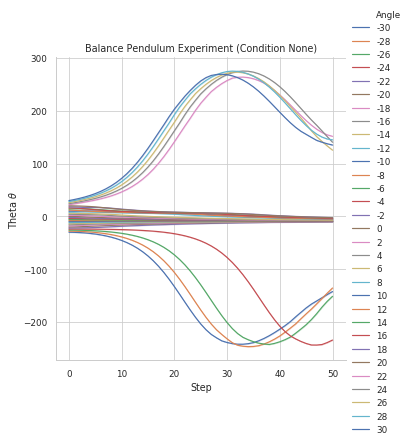

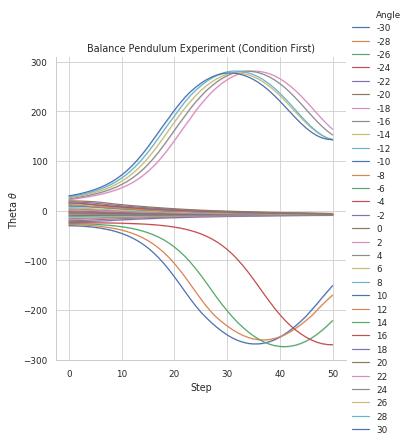

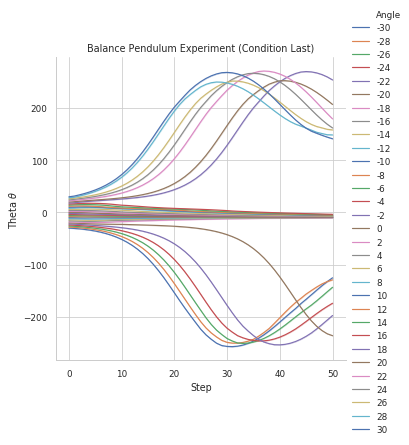

In [150]:

for condition in df["condition"].unique():
    condition_df = df[df["condition"] == condition]
    # plot as relplot
    plan_test_plot = sns.relplot(
        x="step",
        y="theta",
        hue="Angle",
        #style="condition",
        palette=sns.color_palette(n_colors=len(df["Angle"].unique())),
        #row="condition",
        #height=5,
        #linewidth=2,
        legend="brief",
        kind="line",
        data=condition_df
    ).set(title=f"Balance Pendulum Experiment (Condition {condition})",
          xlabel="Step",
          ylabel=r"Theta $\theta$")
    #plt.tight_layout()
    plan_test_plot.fig.savefig(f"graphics/condition_{condition}_angle_test.svg")


In [125]:
#plan_test_plot.fig.savefig("graphics/conditions_angle_test.svg")

In [140]:
df.head()

,condition,condtition,init_angle,init_speed,step,theta,theta_dot,i,init_id,Angle
0,None,None,-30,0,0,-30.000000,0.000000,0,"(-30, 0, None)",-30
1,None,None,-30,0,1,-30.214859,-0.075000,0,"(-30, 0, None)",-30
2,None,None,-30,0,2,-30.651548,-0.152433,0,"(-30, 0, None)",-30
3,None,None,-30,0,3,-31.324185,-0.234795,0,"(-30, 0, None)",-30
4,None,None,-30,0,4,-32.254395,-0.324705,0,"(-30, 0, None)",-30


In [141]:
# inter-condition differences
none_df = df[df["condition"]== "None"]
none_df = none_df.groupby(["init_angle", "init_speed", "step"]).aggregate([np.min, np.max, np.var, np.std])

print(none_df["theta"]["var"].sum())
print(none_df["theta"]["std"].sum())
print(none_df["theta_dot"]["var"].sum())
print(none_df["theta_dot"]["std"].sum())
none_df.head()

0.0
0.0
0.0
0.0


theta                      theta_dot  \
                                 amin       amax  var  std      amin   
init_angle init_speed step                                             
-30        0          0    -30.000000 -30.000000  0.0  0.0  0.000000   
                      1    -30.214859 -30.214859  0.0  0.0 -0.075000   
                      2    -30.651548 -30.651548  0.0  0.0 -0.152433   
                      3    -31.324185 -31.324185  0.0  0.0 -0.234795   
                      4    -32.254395 -32.254395  0.0  0.0 -0.324705   

                                                  i                           \
                                amax  var  std amin amax       var       std   
init_angle init_speed step                                                     
-30        0          0     0.000000  0.0  0.0    0    3  1.666667  1.290994   
                      1    -0.075000  0.0  0.0    0    3  1.666667  1.290994   
                      2    -0.152433  0.0  0.0    0    3  1.666667  1.290994   
                      3    -0.234795  0.0  0.0    0    3  1.666667  1.290994   
                      4    -0.324705  0.0  0.0    0    3  1.666667  1.290994   

                           Angle                
                            amin amax var  std  
init_angle init_speed step                      
-30        0          0      -30  -30   0  0.0  
                      1      -30  -30   0  0.0  
                      2      -30  -30   0  0.0  
                      3      -30  -30   0  0.0  
                      4      -30  -30   0  0.0

In [142]:
# inter condition differences
first_df = df[df["condition"]== "First"]
first_df = first_df.groupby(["init_angle", "init_speed", "step"]).aggregate([np.min, np.max, np.var, np.std])

print(first_df["theta"]["var"].sum())
print(first_df["theta"]["std"].sum())
print(first_df["theta_dot"]["var"].sum())
print(first_df["theta_dot"]["std"].sum())
first_df.head()

0.0
0.0
0.0
0.0


theta                      theta_dot  \
                                 amin       amax  var  std      amin   
init_angle init_speed step                                             
-30        0          0    -30.000000 -30.000000  0.0  0.0  0.000000   
                      1    -30.214859 -30.214859  0.0  0.0 -0.075000   
                      2    -30.651548 -30.651548  0.0  0.0 -0.152433   
                      3    -31.324185 -31.324185  0.0  0.0 -0.234795   
                      4    -32.254395 -32.254395  0.0  0.0 -0.324705   

                                                  i                           \
                                amax  var  std amin amax       var       std   
init_angle init_speed step                                                     
-30        0          0     0.000000  0.0  0.0    0    3  1.666667  1.290994   
                      1    -0.075000  0.0  0.0    0    3  1.666667  1.290994   
                      2    -0.152433  0.0  0.0    0    3  1.666667  1.290994   
                      3    -0.234795  0.0  0.0    0    3  1.666667  1.290994   
                      4    -0.324705  0.0  0.0    0    3  1.666667  1.290994   

                           Angle                
                            amin amax var  std  
init_angle init_speed step                      
-30        0          0      -30  -30   0  0.0  
                      1      -30  -30   0  0.0  
                      2      -30  -30   0  0.0  
                      3      -30  -30   0  0.0  
                      4      -30  -30   0  0.0

In [143]:
# inter condition differences Last
last_df = df[df["condition"]== "Last"]
last_df = last_df.groupby(["init_angle", "init_speed", "step"]).aggregate([np.min, np.max, np.var, np.std])

print(last_df["theta"]["var"].sum())
print(last_df["theta"]["std"].sum())
print(last_df["theta_dot"]["var"].sum())
print(last_df["theta_dot"]["std"].sum())
last_df.head()

0.0
0.0
0.0
0.0


theta                      theta_dot  \
                                 amin       amax  var  std      amin   
init_angle init_speed step                                             
-30        0          0    -30.000000 -30.000000  0.0  0.0  0.000000   
                      1    -30.595926 -30.595926  0.0  0.0 -0.208017   
                      2    -31.426005 -31.426005  0.0  0.0 -0.289752   
                      3    -32.516918 -32.516918  0.0  0.0 -0.380800   
                      4    -33.903366 -33.903366  0.0  0.0 -0.483962   

                                                  i                           \
                                amax  var  std amin amax       var       std   
init_angle init_speed step                                                     
-30        0          0     0.000000  0.0  0.0    0    3  1.666667  1.290994   
                      1    -0.208017  0.0  0.0    0    3  1.666667  1.290994   
                      2    -0.289752  0.0  0.0    0    3  1.666667  1.290994   
                      3    -0.380800  0.0  0.0    0    3  1.666667  1.290994   
                      4    -0.483962  0.0  0.0    0    3  1.666667  1.290994   

                           Angle                
                            amin amax var  std  
init_angle init_speed step                      
-30        0          0      -30  -30   0  0.0  
                      1      -30  -30   0  0.0  
                      2      -30  -30   0  0.0  
                      3      -30  -30   0  0.0  
                      4      -30  -30   0  0.0

In [144]:
# differences between conditions
gb = df.groupby(["init_angle", "init_speed", "step"])
gb_df = gb.aggregate([np.min, np.max, np.var, np.std])

In [145]:
print(gb_df["theta"]["var"].mean())
print(gb_df["theta"]["std"].mean())
print(gb_df["theta_dot"]["var"].mean())
print(gb_df["theta_dot"]["std"].mean())
gb_df.head()

690.3446777800625
10.262836198623111
0.34712266531455105
0.2755882412135917


theta                                 \
                                 amin       amax       var       std   
init_angle init_speed step                                             
-30        0          0    -30.000000 -30.000000  0.000000  0.000000   
                      1    -30.595926 -30.214859  0.035203  0.187624   
                      2    -31.426005 -30.651548  0.145402  0.381317   
                      3    -32.516918 -31.324185  0.344875  0.587261   
                      4    -33.903366 -32.254395  0.659177  0.811897   

                           theta_dot                                  i       \
                                amin      amax       var       std amin amax   
init_angle init_speed step                                                     
-30        0          0     0.000000  0.000000  0.000000  0.000000    0    3   
                      1    -0.208017 -0.075000  0.004289  0.065493    0    3   
                      2    -0.289752 -0.152433  0.004571  0.067611    0    3   
                      3    -0.380800 -0.234795  0.005168  0.071888    0    3   
                      4    -0.483962 -0.324705  0.006149  0.078413    0    3   

                                               Angle                
                                 var       std  amin amax var  std  
init_angle init_speed step                                          
-30        0          0     1.363636  1.167748   -30  -30   0  0.0  
                      1     1.363636  1.167748   -30  -30   0  0.0  
                      2     1.363636  1.167748   -30  -30   0  0.0  
                      3     1.363636  1.167748   -30  -30   0  0.0  
                      4     1.363636  1.167748   -30  -30   0  0.0